
# YOLOv8 Binary Object Detection and Cropping Pipeline



## Instructions on How to use this notebook:
1. Click on Runtime -> Change runtime type -> Click t4 GPU (this is the free option if you have paid subscription feel free to use other GPU)

2. Next Use the side to upload your image file

3. Replace path below with your image path. To do this use sidebar and right click on image file name ans select copy path. Paste this into `org_image` variable in the cell below and run the cell

In [19]:
org_img = "/content/W5_20220509_2_ST220182_A_JPG.rf.e306f0dc23897e2094b74be4951e684c.jpg"

Run the cell below to download the requirements and  model weights and install all required modules

In [2]:
!pip install gdown
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1VAd8ZZJOVgIyhvx2uWxMaXBxJveJkddS" -O requirements.txt
!gdown 1eul2LTjjFX4ye3QXn2l4fNP6Cz1ltUIx -O cls_model.keras
!gdown 1IdQXwGsizccY9TSPiL2dMmVFUAZ58NRr -O detect_model.pt
!pip install -r requirements.txt

--2025-07-22 17:02:24--  https://drive.google.com/uc?export=download&id=1VAd8ZZJOVgIyhvx2uWxMaXBxJveJkddS
Resolving drive.google.com (drive.google.com)... 142.250.141.101, 142.250.141.138, 142.250.141.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1VAd8ZZJOVgIyhvx2uWxMaXBxJveJkddS&export=download [following]
--2025-07-22 17:02:24--  https://drive.usercontent.google.com/download?id=1VAd8ZZJOVgIyhvx2uWxMaXBxJveJkddS&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 768 [application/octet-stream]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     768  --.-KB/s    in 

## Run the script below runs the inference on the image.
A summary of results is saved in `class_summary.csv` and the each image path, predicted class and confidence is saved in `detailed_predictions.csv`. Individual cropped images in their corresponding prdiction folders are save in `results`. The `coco_annotations.json` file contains the annotations for the image in coco format.

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from collections import defaultdict
import csv
import pandas as pd
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
import json

crop_dir = 'cropped_results'
output_dir = 'results'
detailed_csv_path = 'detailed_predictions.csv'
summary_csv_path = 'class_summary.csv'
coco_json_path = 'coco_annotations.json'

# =======================
class_names = ['Caddisfly', 'Dipteran', 'Mayfly', 'Other', 'Stonefly', 'Terrestrial']
class_thresholds = {
    0: 0.4,   # Caddisfly
    1: 0.4,   # Dipteran
    2: 0.4,   # Mayfly
    3: 0.0,   # Other
    4: 0.4,   # Stonefly
    5: 0.4    # Terrestrial
}
OTHER_IDX = 3  # Index for "Other" class
img_size = (224, 224)

# =======================
# 1. Load Classification Model
# =======================
if tf.config.list_physical_devices('GPU'):
    with tf.device('/GPU:0'):
        model_cls = load_model('/content/cls_model.keras')
else:
    model_cls = load_model('/content/cls_model.keras')

# =======================
# 2. Load Detection Model
# =======================
detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path='/content/detect_model.pt',
    confidence_threshold=0.2
)

# =======================
# 3. Get Sliced Prediction
# =======================
result = get_sliced_prediction(
    org_img,
    detection_model,
    slice_height=752,
    slice_width=752,
    overlap_height_ratio=0.3,
    overlap_width_ratio=0.3,
    postprocess_type="GREEDYNMM"
)

# =======================
# 4. Crop and Record Annotations
# =======================
def crop_predictions_from_sahi(image_path, sahi_result, conf_thresh=0.05):
    img = cv2.imread(image_path)
    crops = []
    annotations_map = {}
    for idx, obj in enumerate(sahi_result.object_prediction_list):
        if obj.score.value < conf_thresh:
            continue

        x1, y1, x2, y2 = map(int, obj.bbox.to_xyxy())
        crop = img[y1:y2, x1:x2]
        crops.append(crop)

        filename = f"insect_{idx + 1}.jpg"
        annotations_map[filename] = {
            "bbox": [x1, y1, x2 - x1, y2 - y1],
            "score": float(obj.score.value),
            "category": None
        }

    return crops, annotations_map

def save_crops(crops, save_dir, base_filename="crop"):
    os.makedirs(save_dir, exist_ok=True)
    for idx, crop in enumerate(crops):
        save_path = os.path.join(save_dir, f"{base_filename}_{idx + 1}.jpg")
        cv2.imwrite(save_path, crop)
    print(f"{len(crops)} cropped images saved to {save_dir}")

crops, annotations_map = crop_predictions_from_sahi(org_img, result)
save_crops(crops, save_dir=crop_dir, base_filename="insect")

# =======================
# 5. Classify & Update Annotations
# =======================
os.makedirs(output_dir, exist_ok=True)
for class_name in class_names:
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

class_counts = defaultdict(int)

with open(detailed_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name', 'Raw Prediction', 'Confidence', 'Threshold', 'Final Prediction'])

    for file_name in os.listdir(crop_dir):
        if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img_path = os.path.join(crop_dir, file_name)
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0
        img_batch = np.expand_dims(img_array, axis=0)

        preds = model_cls.predict(img_batch, verbose=0)
        probs = preds[0]
        pred_idx = np.argmax(probs)
        raw_class = class_names[pred_idx]
        confidence = float(probs[pred_idx])
        threshold = class_thresholds.get(pred_idx, 0.5)

        if confidence >= threshold:
            final_idx = pred_idx
            rerouted = False
        else:
            final_idx = OTHER_IDX
            rerouted = True

        final_class = class_names[final_idx]
        class_counts[final_class] += 1

        writer.writerow([
            file_name,
            raw_class,
            round(confidence, 4),
            threshold,
            final_class
        ])

        # Annotate image with prediction
        plt.figure()
        plt.imshow(img)
        plt.title(f"{final_class} ({confidence:.2f})")
        plt.axis('off')
        save_path = os.path.join(output_dir, final_class, f"{os.path.splitext(file_name)[0]}_pred.png")
        plt.savefig(save_path)
        plt.close()

        # Update hash map
        if file_name in annotations_map:
            annotations_map[file_name]["category"] = final_class

        if rerouted:
            print(f"{file_name} → {raw_class} ({confidence:.2f}) ➡ rerouted to 'Other'")
        else:
            print(f"{file_name} → {final_class} ({confidence:.2f}) ✅")

# =======================
# 6. Save Summary CSV
# =======================
with open(summary_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Class', 'Count'])
    for class_name in class_names:
        writer.writerow([class_name, class_counts[class_name]])

print(f"\nSummary CSV saved to: {summary_csv_path}")
print("Class Distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} times")


# =======================
# 7. Convert to COCO Format and Save
# =======================
def convert_to_coco(annotations_map, org_img_path, image_id=1):
    # Read image to get dimensions
    img = cv2.imread(org_img_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image from path: {org_img_path}")
    height, width = img.shape[:2]

    categories = [{"id": i, "name": name} for i, name in enumerate(class_names)]
    images = [{
        "id": image_id,
        "file_name": os.path.basename(org_img_path),
        "height": height,
        "width": width
    }]
    annotations = []
    annotation_id = 1

    for fname, ann in annotations_map.items():
        if ann["category"] is None:
            continue
        category_id = class_names.index(ann["category"])
        coco_ann = {
            "id": annotation_id,
            "image_id": image_id,
            "category_id": category_id,
            "bbox": ann["bbox"],
            "area": ann["bbox"][2] * ann["bbox"][3],
            "iscrowd": 0
        }
        annotations.append(coco_ann)
        annotation_id += 1

    return {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }
coco_dict = convert_to_coco(annotations_map, org_img)
with open(coco_json_path, 'w') as f:
    json.dump(coco_dict, f, indent=4)

print(f"COCO annotation JSON saved to {coco_json_path}")

Performing prediction on 9 slices.
157 cropped images saved to cropped_results
insect_151.jpg → Other (0.55) ✅
insect_21.jpg → Other (0.44) ✅
insect_62.jpg → Dipteran (0.89) ✅
insect_93.jpg → Dipteran (0.92) ✅
insect_64.jpg → Dipteran (0.90) ✅
insect_76.jpg → Dipteran (0.88) ✅
insect_33.jpg → Other (0.87) ✅
insect_101.jpg → Dipteran (0.67) ✅
insect_43.jpg → Dipteran (0.91) ✅
insect_67.jpg → Dipteran (0.85) ✅
insect_5.jpg → Dipteran (0.54) ✅
insect_6.jpg → Dipteran (0.89) ✅
insect_150.jpg → Other (0.69) ✅
insect_118.jpg → Dipteran (0.92) ✅
insect_126.jpg → Other (0.87) ✅
insect_34.jpg → Other (0.56) ✅
insect_2.jpg → Caddisfly (0.50) ✅
insect_124.jpg → Other (0.82) ✅
insect_153.jpg → Dipteran (0.94) ✅
insect_80.jpg → Dipteran (0.87) ✅
insect_156.jpg → Other (0.81) ✅
insect_70.jpg → Other (0.49) ✅
insect_44.jpg → Dipteran (0.92) ✅
insect_141.jpg → Other (0.56) ✅
insect_45.jpg → Dipteran (0.40) ✅
insect_13.jpg → Dipteran (0.92) ✅
insect_27.jpg → Dipteran (0.89) ✅
insect_137.jpg → Dipteran 

## Run the code below to visualise results on the original image

✅ Saved annotated image to ./annotated_output.jpg


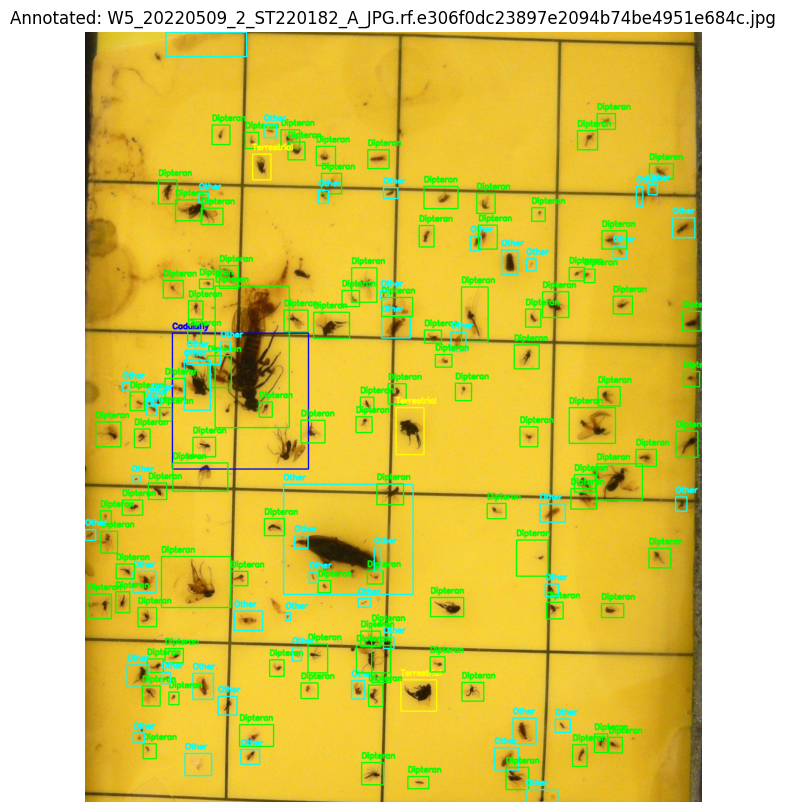

In [21]:
import json
import cv2
import os
import matplotlib.pyplot as plt

def get_color_map(categories):
    """Assigns a unique BGR color to each class"""
    base_colors = [
        (255, 0, 0),    # Blue
        (0, 255, 0),    # Green
        (0, 0, 255),    # Red
        (255, 255, 0),  # Cyan
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Yellow
        (128, 0, 128),  # Purple
        (0, 128, 128),  # Teal
        (128, 128, 0),  # Olive
        (255, 165, 0),  # Orange
    ]
    color_map = {}
    for i, cat in enumerate(categories):
        color_map[cat['id']] = base_colors[i % len(base_colors)]
    return color_map

def visualize_coco_annotations(coco_json_path, image_folder, save_output=False, output_path=None):
    with open(coco_json_path, 'r') as f:
        coco = json.load(f)

    images = {img['id']: img for img in coco['images']}
    categories = {cat['id']: cat['name'] for cat in coco['categories']}
    color_map = get_color_map(coco['categories'])

    annotations = coco['annotations']

    for image_id, image_info in images.items():
        img_path = os.path.join(image_folder, image_info['file_name'])
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Skipping {img_path} (not found)")
            continue

        for ann in [a for a in annotations if a['image_id'] == image_id]:
            x, y, w, h = map(int, ann['bbox'])
            category_id = ann['category_id']
            category_name = categories[category_id]
            color = color_map[category_id]

            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, category_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, color, 2, cv2.LINE_AA)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Annotated: {image_info['file_name']}")

        if save_output:
            output_dir = os.path.dirname(output_path)
            if output_dir:
                os.makedirs(output_dir, exist_ok=True)
            cv2.imwrite(output_path, img)
            print(f"✅ Saved annotated image to {output_path}")
        else:
            plt.show()


# Example usage
visualize_coco_annotations(
    coco_json_path='coco_annotations.json',
    image_folder='/content',  # Folder where the original image is
    save_output=True,        # Set to True to save instead of show
    output_path='./annotated_output.jpg')


## Run cell below to download csv files and image prediction folder

In [17]:
from google.colab import files

# Download csv files
files.download('/content/detailed_predictions.csv')
files.download('/content/class_summary.csv')

#Download annotation
files.download('/content/coco_annotations.json')

#Download annotated image
files.download('/content/annotated_output.jpg')

#Download image folder
import shutil

# Zip the folder
shutil.make_archive('/content/results', 'zip', '/content/results')

# Download the zip file
files.download('/content/results.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Want to run inference with another image? Run cell below to clear out current results.

In [18]:
!rm -rf /content/cropped_results
!rm -rf /content/results/
!rm -rf /content/detailed_predictions.csv
!rm -rf /content/class_summary.csv
!rm -rf /content/results.zip
!rm -rf /content/coco_annotations.json
!rm -rf /content/annotated_output.jpg